### Partie 0 — Setup & chargement des données (5 min)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(123)
plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True


In [3]:
# Cellule 1 — Chargement des données Rdatasets (mêmes données que les packages R ismev/texmex)


port = pd.read_csv("portpirie_yearly_maxima.csv",index_col=0)
rain = pd.read_csv("daily_rainfall_data.csv",index_col=0)
display(port.head(5))
print()
display(rain.head(5))

,Year,SeaLevel
rownames,,
1,1923,4.03
2,1924,3.83
3,1925,3.65
4,1926,3.88
5,1927,4.01


,daily_rainfall
rownames,
1,0.0
2,2.3
3,1.3
4,6.9
5,4.6


### Partie 1 — Maxima par blocs (Port Pirie) → GEV (35 min)

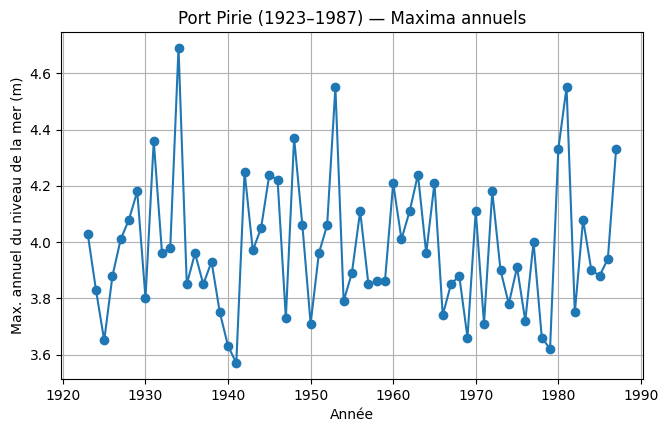

In [4]:
# 1A
fig, ax = plt.subplots()
ax.plot(port["Year"], port["SeaLevel"], marker="o")
ax.set_xlabel("Année"); ax.set_ylabel("Max. annuel du niveau de la mer (m)")
ax.set_title("Port Pirie (1923–1987) — Maxima annuels")
plt.show()



In [5]:
# 1B Fit des paramètres
data_pp = port["SeaLevel"].values
c, loc, scale = stats.genextreme.fit(data_pp)  # MLE ; c = -xi
xi_hat, mu_hat, sigma_hat = -c, loc, scale
xi_hat, mu_hat, sigma_hat


(np.float64(-0.05010534785328627),
 np.float64(3.874758730628963),
 np.float64(0.19803814023673208))

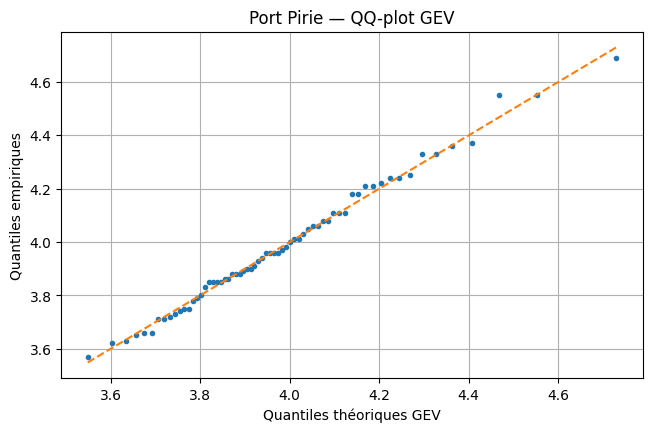

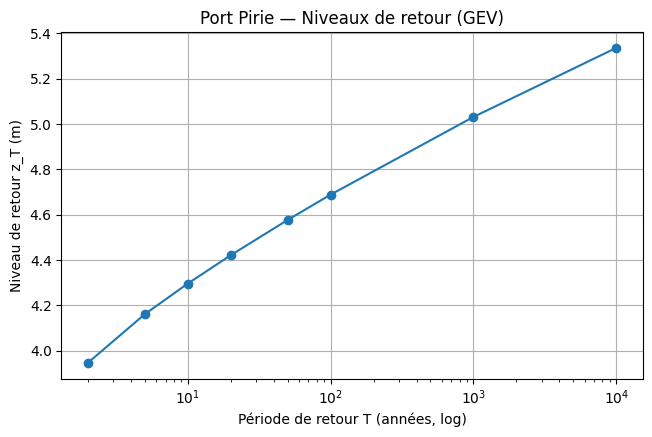

In [6]:
# 1C Diagnostic

# QQ-plot
q = (np.arange(1, len(data_pp)+1) - 0.5) / len(data_pp)
gev_q = stats.genextreme.ppf(q, -xi_hat, loc=mu_hat, scale=sigma_hat)
emp_q = np.sort(data_pp)

plt.figure(); plt.plot(gev_q, emp_q, 'o', ms=3)
mn, mx = min(gev_q.min(), emp_q.min()), max(gev_q.max(), emp_q.max())
plt.plot([mn, mx], [mn, mx], '--')
plt.xlabel("Quantiles théoriques GEV"); plt.ylabel("Quantiles empiriques")
plt.title("Port Pirie — QQ-plot GEV")
plt.show()


T = np.array([2,5,10,20,50,100,1e3,1e4])
p = 1 - 1/T
# z_gev = gev_return_level(p, mu_hat, sigma_hat, xi_hat)
z_gev = stats.genextreme.ppf(p, -xi_hat, loc=mu_hat, scale=sigma_hat)

plt.figure(); plt.plot(T, z_gev, '-o')
plt.xscale("log"); plt.xlabel("Période de retour T (années, log)")
plt.ylabel("Niveau de retour z_T (m)"); plt.title("Port Pirie — Niveaux de retour (GEV)")
plt.show()


### Part 2 Exceedances above a threshold

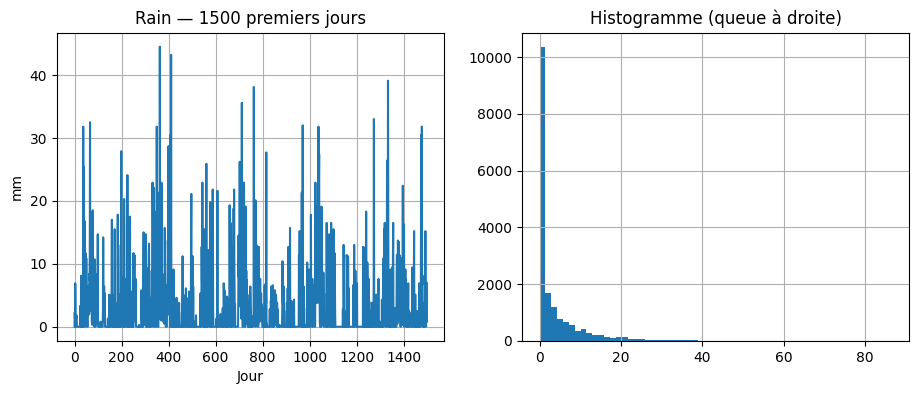

In [7]:
# 2A Vue d'ensemble Rain
x = rain["daily_rainfall"].values
fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(x[:1500]); ax[0].set_title("Rain — 1500 premiers jours"); ax[0].set_ylabel("mm"); ax[0].set_xlabel("Jour")
ax[1].hist(x, bins=60); ax[1].set_title("Histogramme (queue à droite)")
plt.show()

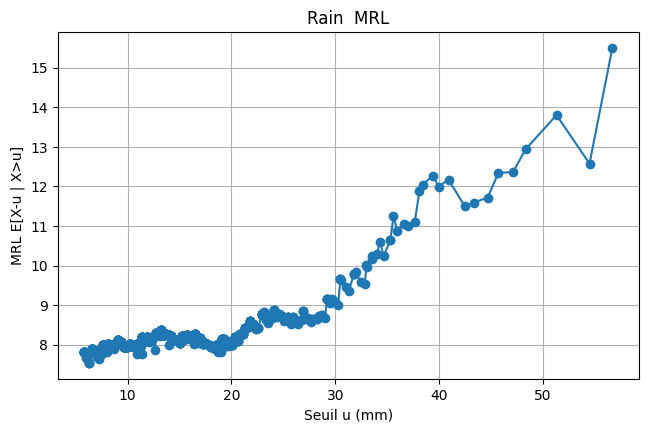

In [8]:
# 2B Mean Residual Life (MRL) + compte d'excès
def mean_residual_life(x, u_grid):
    mrl = []
    for u in u_grid:
        exc = x[x > u] - u
        mrl.append(np.nan if exc.size==0 else exc.mean())
    return np.array(mrl)

u_grid = np.quantile(x, np.linspace(0.80, 0.9995, 1000))
mrl = mean_residual_life(x, u_grid)

fig, ax1 = plt.subplots()
ax1.plot(u_grid, mrl, '-o'); ax1.set_xlabel("Seuil u (mm)"); ax1.set_ylabel("MRL E[X-u | X>u]")
plt.title("Rain  MRL")
plt.show()


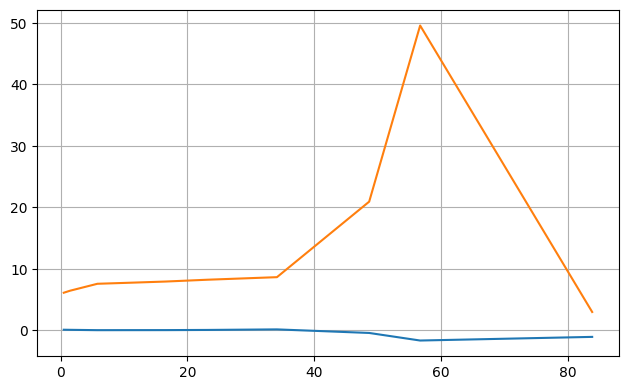

In [10]:
# Ajustements GPD pour plusieurs seuils (stabilité)
def fit_gpd_excesses(x, u):
    y = x[x > u] - u
    c, loc, scale = stats.genpareto.fit(y, floc=0.0)  # SciPy: c = xi, scale = beta
    xi, beta = c, scale
    return xi, beta, y

u_candidates = np.quantile(x, [0.5,0.6,0.8,0.9,0.95,0.98,0.995,0.999,0.9995,0.9999])
list_est = []
for u in u_candidates:
    xi, beta, y = fit_gpd_excesses(x, u)
    list_est.append((u, xi, beta))

list_u = [est[0] for est in list_est]
plt.plot(list_u,[est[1] for est in list_est])
plt.plot(list_u,[est[2] for est in list_est])
